In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import imageio
import pandas as pd

In [62]:
data_dir = '~/datasets/translation_academy_empty_goal_close_320x480_gray_SMALL'
labels = pd.read_csv(data_dir + '/labels.csv')
d = labels[['camera_translation_x', 'camera_translation_y']].iloc[0].to_numpy()
d

array([20, -1])

(1, 320, 480)

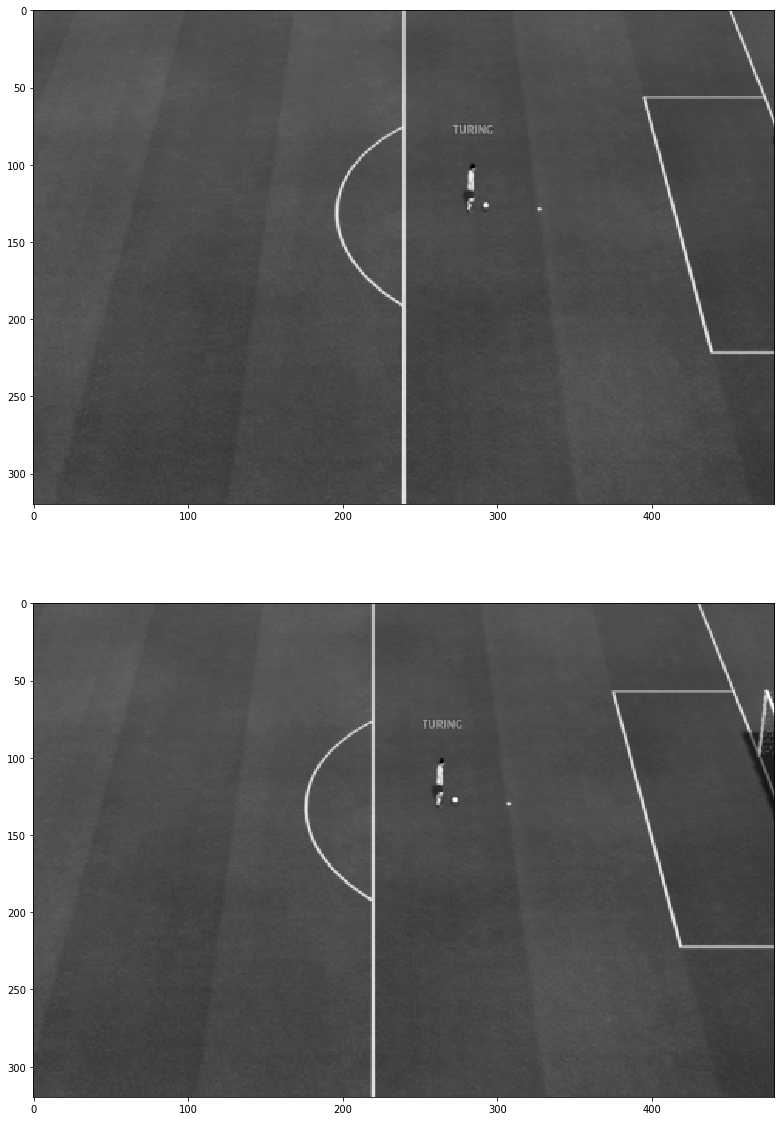

In [15]:
import skimage
im1 = imageio.imread(data_dir + '/image00.png')
im2 = imageio.imread(data_dir + '/image01.png')
im1 = skimage.img_as_float32(im1)
im2 = skimage.img_as_float32(im2)
im1 = torch.tensor(im1).unsqueeze(0)
im2 = torch.tensor(im2).unsqueeze(0)
fig, ax = plt.subplots(2, figsize=(20,20))
ax[0].imshow(im1.squeeze(0), cmap='gray')
ax[1].imshow(im2.squeeze(0), cmap='gray')
C,H,W = im1.shape
C,H,W

In [34]:
import sfmnet
m = sfmnet.SpatialTransform(C=1, H=H, W=W)



(tensor([[[0.0042, 0.1250]]]), torch.Size([1, 1, 2]))

In [81]:
flow = torch.tensor(d * np.array([2/W, 2/H]), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
flow, flow.shape

(tensor([[[ 0.0833, -0.0063]]]), torch.Size([1, 1, 2]))

In [82]:
im2_estimate = m(im1.unsqueeze(0), flow.unsqueeze(0))
im2_estimate.shape

torch.Size([1, 1, 320, 480])

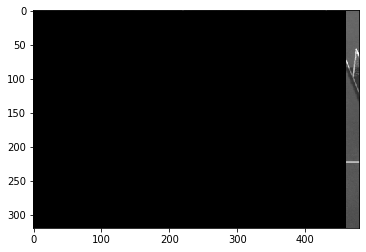

In [83]:
plt.imshow((im2 - im2_estimate)[0,0], cmap='gray', vmin=0., vmax=1.)